# Chapter 4 Exercises. Geocentric Models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import altair as alt

# to support rendering on github
alt.renderers.enable("mimetype")

import numpy as np
import pandas as pd
from scipy import stats

## 4E3

Using the model definition above, write down the appropriate form of Bayes’ theorem that includes the proper likelihood and priors.

$$
P(\mu,\sigma|y_i) \propto P(y|\mu,\sigma) \times P(\mu) \times P(\sigma)\\
P(y|\mu,\sigma) = \prod_i \text{Normal}(y_i|\mu, \sigma)
$$

## 4M1
For the model definition below, simulate observed y values from the prior (not the posterior).

$$
y_i \sim \text{Normal}(\mu, \sigma) \\
\mu \sim \text{Normal}(0, 10) \\
\sigma \sim \text{Exponential}(1)
$$

In [3]:
n = 5000
mu = np.random.normal(0, 10, n)
sigma = np.random.exponential(1, n)
y_sim = np.random.normal(mu, sigma)

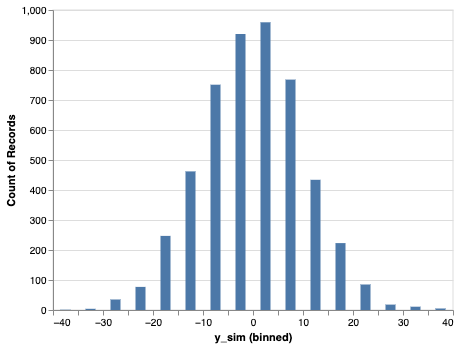

In [4]:
samples_df = pd.DataFrame({"y_sim": y_sim})
hist = (
    alt.Chart(samples_df)
    .mark_bar(size=10)
    .encode(
        x=alt.X("y_sim", bin=alt.BinParams(maxbins=20)),
        y="count()",
    )
)

hist

## 4M4

A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical model definition for this regression, using any variable names and priors you choose. Be prepared to defend your choice of priors.

$$
h_i \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i = \alpha + \beta y_i\\
\alpha \sim \text{Normal}(\bar{h},?) \\
\beta \sim \text{LogNormal}(0,?) \\
\sigma \sim \text{Uniform}(0,10)
$$


## 4M6

Now suppose I tell you that the variance among heights for students of the same age is never more than 64cm. How does this lead you to revise your priors?

$$
\sigma \sim \text{Uniform}(0,64)
$$

## 4H1

The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

<table>
<thead><tr>
<th>Individual</th>
<th>Weight</th>
<th>Expected height</th>
<th>89% interval</th>
</tr>
</thead>
<tbody>
<tr>
<td>1</td>
<td>46.95</td>
<td>?</td>
<td>?</td>
</tr>
<tr>
<td>2</td>
<td>43.72</td>
<td>?</td>
<td>?</td>
</tr>
<tr>
<td>3</td>
<td>64.78</td>
<td>?</td>
<td>?</td>
</tr>
<tr>
<td>4</td>
<td>32.59</td>
<td>?</td>
<td>?</td>
</tr>
<tr>
<td>5</td>
<td>54.63</td>
<td>?</td>
<td>?</td>
</tr>
</tbody>
</table>

In [5]:
# load data
howell1 = pd.read_csv("../data/Howell1.csv", delimiter=";")
howell1_18 = howell1[howell1.age >= 18]
howell1_18

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0


In [6]:
height = howell1_18.height.to_numpy()
weight = howell1_18.weight.to_numpy()

weight_mean = weight.mean()
weight = weight - weight_mean

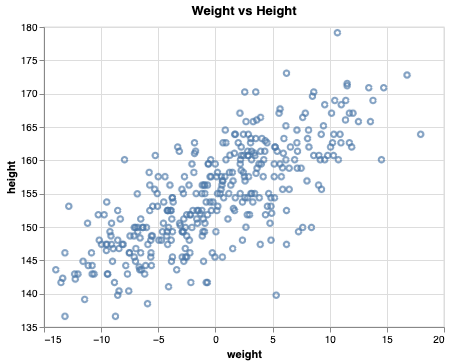

In [7]:
df = pd.DataFrame({"height": height, "weight": weight})

data_chart = (
    alt.Chart(df, title="Weight vs Height")
    .mark_point()
    .encode(
        alt.X("weight", scale=alt.Scale(zero=False)),
        alt.Y("height", scale=alt.Scale(zero=False)),
    )
)
data_chart

In [8]:
# workaround to make stan run in jupyter
# https://pystan.readthedocs.io/en/latest/faq.html#how-can-i-use-pystan-with-jupyter-notebook-or-jupyterlab
import nest_asyncio

nest_asyncio.apply()
del nest_asyncio

In [9]:
from functools import reduce

import stan

### Check priors

In [10]:
code = """
data {
  int<lower=0> n;   // number of points
  vector[n] weight;
  vector[n] height;
}
parameters {
  real alpha;
  real<lower=0> beta;
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(160, 10);
  beta ~ lognormal(0, 1);
  sigma ~ normal(10, 5); // replace uniform with normal to help gradients
  
  // likelihood
  height ~ normal(alpha + beta * weight, sigma);
}
"""

# set empty data, to sample from priors
data = {"n": 0, "weight": [], "height": []}

In [11]:
%%capture
# capture output because stan is too spammy when building model
prior = stan.build(code, data=data, random_seed=42)

In [12]:
%%capture
prior_fit = prior.sample(num_chains=4, num_samples=1000)

In [13]:
prior_fit_df = prior_fit.to_frame()
prior_fit_df[["alpha", "beta", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,4000.0,159.751781,10.046169,122.377612,153.119566,159.848281,166.400878,195.965721
beta,4000.0,1.682587,2.059266,0.035455,0.513419,1.028973,2.020387,30.350117
sigma,4000.0,10.139650,4.815363,0.031047,6.538209,9.869517,13.371555,27.449508


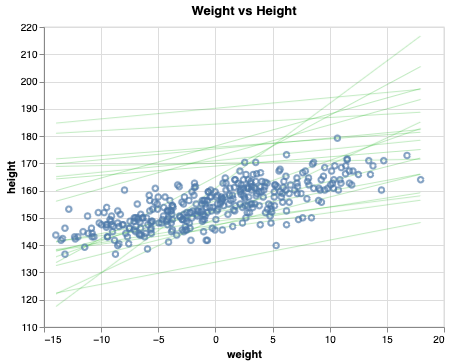

In [14]:
weight_grid = np.linspace(weight.min(), weight.max())

lines = []

for i in range(20):
    a = prior_fit["alpha"][0, i]
    b = prior_fit["beta"][0, i]

    line = a + b * weight_grid
    df = pd.DataFrame({"weight": weight_grid, "height": line})

    line = (
        alt.Chart(df)
        .mark_line(color="#00AA00", strokeWidth=0.5, opacity=0.5)
        .encode(
            x="weight",
            y="height",
        )
    )

    lines.append(line)

reduce(lambda a, b: a + b, lines) + data_chart

### Fit model to data

In [15]:
code = """
data {
  int<lower=0> n;   // number of points
  vector[n] weight;
  vector[n] height;
}
parameters {
  real alpha;
  real<lower=0> beta;
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(160, 10);
  beta ~ lognormal(0, 1);
  sigma ~ normal(10, 5); // replace uniform with normal to help gradients
  
  // likelihood
  height ~ normal(alpha + beta * weight, sigma);
}
"""

assert weight.shape == height.shape
data = {"n": len(weight), "weight": weight, "height": height}

In [16]:
%%capture
# capture output because stan is too spammy when building model
posterior = stan.build(code, data=data, random_seed=42)

In [17]:
%%capture
fit = posterior.sample(num_chains=4, num_samples=2000)

In [18]:
fit_df = fit.to_frame()
fit_df[["alpha", "beta", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,8000.0,154.597539,0.273741,153.687260,154.410568,154.598411,154.784901,155.538755
beta,8000.0,0.903641,0.043231,0.730257,0.874515,0.903489,0.933150,1.074189
sigma,8000.0,5.112031,0.195348,4.470016,4.973222,5.103862,5.241647,5.949173


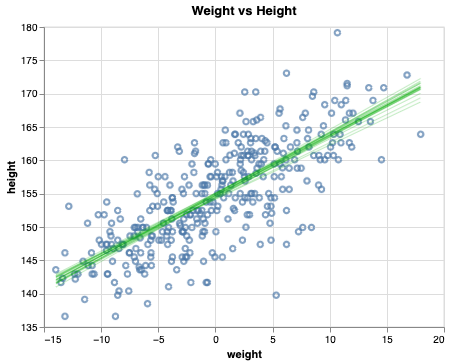

In [19]:
weight_grid = np.linspace(weight.min(), weight.max())

lines = []

for i in range(20):
    a = fit["alpha"][0, i]
    b = fit["beta"][0, i]

    line = a + b * weight_grid
    df = pd.DataFrame({"weight": weight_grid, "height": line})

    line = (
        alt.Chart(df)
        .mark_line(color="#00AA00", strokeWidth=0.5, opacity=0.5)
        .encode(
            x="weight",
            y="height",
        )
    )

    lines.append(line)

data_chart + reduce(lambda a, b: a + b, lines)

### Predict heights

In [20]:
import statreth as sr

In [21]:
individual_weights = np.array([46.95, 43.72, 64.78, 32.59, 54.63])

In [22]:
rows = []

alpha_map = fit_df["alpha"].mean()
beta_map = fit_df["beta"].mean()

for w in individual_weights:
    w_centered = w - weight_mean
    h_expected = alpha_map + beta_map * w_centered

    alphas = fit_df["alpha"].values
    betas = fit_df["beta"].values

    # height means for given individual under the model
    mus = alphas + betas * w_centered
    sigmas = fit_df["sigma"].values
    # sample individual heights
    h = np.random.normal(mus, sigmas)

    cred_low, cred_high = sr.hdi(h, mass=0.89)

    row = {
        "weight": w,
        "expected height": h_expected,
        "std": h.std(),
        "cred low": cred_low,
        "cred high": cred_high,
    }
    rows.append(row)

pd.DataFrame(rows)

,weight,expected height,std,cred low,cred high
0,46.95,156.368236,5.133235,148.298970,164.654650
1,43.72,153.449477,5.153305,145.125867,161.549116
2,64.78,172.480151,5.212669,164.099787,180.705518
3,32.59,143.391955,5.179045,135.643343,152.291086
4,54.63,163.308197,5.139912,155.327779,171.774184


## 4H2

Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right, you should end up with a new data frame with 192 rows in it.

A. Fit a linear regression to these data, using quap. Present and interpret the estimates. For every 10 units of increase in weight, how much taller does the model predict a child gets?

B. Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Super- impose the MAP regression line and 89% interval for the mean. Also superimpose the 89% interval for predicted heights.

C. What aspects of the model fit concern you? Describe the kinds of assumptions you would change, if any, to improve the model. You don’t have to write any new code. Just explain what the model appears to be doing a bad job of, and what you hypothesize would be a better model.

In [23]:
howell1_18_under = howell1[howell1.age < 18]
howell1_18_under

,height,weight,age,male
18,121.920,19.617854,12.0,1
19,105.410,13.947954,8.0,0
20,86.360,10.489315,6.5,0
23,129.540,23.586784,13.0,1
24,109.220,15.989118,7.0,0
...,...,...,...,...
535,114.935,17.519991,7.0,1
536,67.945,7.229122,1.0,0
538,76.835,8.022908,1.0,1
539,145.415,31.127751,17.0,1


In [24]:
height = howell1_18_under.height.to_numpy()
weight = howell1_18_under.weight.to_numpy()

weight_mean = weight.mean()
weight = weight - weight_mean

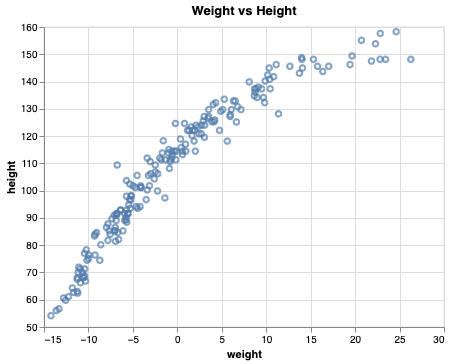

In [25]:
df = pd.DataFrame({"height": height, "weight": weight})

data_chart = (
    alt.Chart(df, title="Weight vs Height")
    .mark_point()
    .encode(
        alt.X("weight", scale=alt.Scale(zero=False)),
        alt.Y("height", scale=alt.Scale(zero=False)),
    )
)
data_chart

In [26]:
# reuse the same model including priors
code = """
data {
  int<lower=0> n;   // number of points
  vector[n] weight;
  vector[n] height;
}
parameters {
  real alpha;
  real<lower=0> beta;
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(160, 10);
  beta ~ lognormal(0, 1);
  sigma ~ normal(10, 5); // replace uniform with normal to help gradients
  
  // likelihood
  height ~ normal(alpha + beta * weight, sigma);
}
"""

assert weight.shape == height.shape
data = {"n": len(weight), "weight": weight, "height": height}

In [27]:
%%capture
# capture output because stan is too spammy when building model
posterior = stan.build(code, data=data, random_seed=42)

In [28]:
%%capture
fit = posterior.sample(num_chains=4, num_samples=2000)

In [29]:
fit_df = fit.to_frame()
fit_df[["alpha", "beta", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,8000.0,108.511764,0.622983,106.191486,108.102748,108.501620,108.940170,110.847850
beta,8000.0,2.716198,0.070140,2.474480,2.670151,2.716440,2.762857,2.984513
sigma,8000.0,8.559074,0.447375,7.181406,8.246191,8.534308,8.845703,10.440158


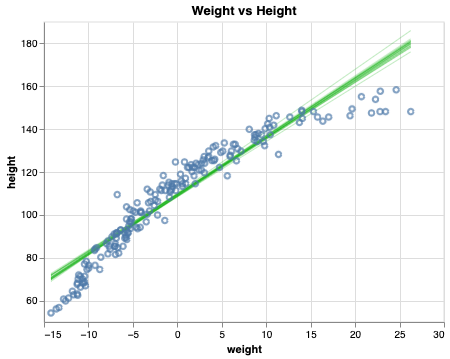

In [30]:
weight_grid = np.linspace(weight.min(), weight.max())

lines = []

for i in range(20):
    a = fit["alpha"][0, i]
    b = fit["beta"][0, i]

    line = a + b * weight_grid
    df = pd.DataFrame({"weight": weight_grid, "height": line})

    line = (
        alt.Chart(df)
        .mark_line(color="#00AA00", strokeWidth=0.5, opacity=0.5)
        .encode(
            x="weight",
            y="height",
        )
    )

    lines.append(line)

reduce(lambda a, b: a + b, lines) + data_chart

For every 10 units of increase in weight, how much taller does the model predict a child gets?

In [31]:
fit["beta"].mean() * 10

27.16198168290954

B. Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Super- impose the MAP regression line and 89% interval for the mean. Also superimpose the 89% interval for predicted heights.

In [32]:
rows = []

alpha_map = fit_df["alpha"].mean()
beta_map = fit_df["beta"].mean()

for w in weight_grid:
    alphas = fit_df["alpha"].values
    betas = fit_df["beta"].values

    mus = alphas + betas * w
    mu_low, mu_high = sr.hdi(mus, mass=0.89)

    sigmas = fit_df["sigma"].values
    # sample heights at w
    hs = np.random.normal(mus, sigmas)
    h_low, h_high = sr.hdi(hs, mass=0.89)

    h_map = alpha_map + beta_map * w

    row = {
        "weight": w,
        "h_map": h_map,
        "mu_low": mu_low,
        "mu_high": mu_high,
        "h_low": h_low,
        "h_high": h_high,
    }

    rows.append(row)

df = pd.DataFrame(rows)

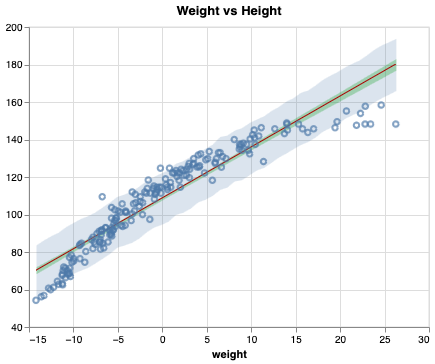

In [33]:
compatibility_band = (
    alt.Chart(df)
    .encode(alt.X("weight"))
    .mark_area(opacity=0.3, color="#00AA00")
    .encode(alt.Y("mu_high", axis=alt.Axis(title=None)), alt.Y2("mu_low"))
)

prediction_band = (
    alt.Chart(df)
    .encode(alt.X("weight"))
    .mark_area(opacity=0.2)
    .encode(alt.Y("h_high"), alt.Y2("h_low"))
)

map_line = (
    alt.Chart(df)
    .mark_line(color="#AA0000", strokeWidth=1)
    .encode(x="weight", y="h_map")
)

# alt.layer(compatibility_band, prediction_band, data_chart)
compatibility_band + prediction_band + map_line + data_chart

## 4H3

Suppose a colleague of yours, who works on allometry, glances at the practice problems just above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body weight that scales with height!” Let’s take your colleague’s advice and see what happens.

In [34]:
height = howell1.height.to_numpy()
weight = howell1.weight.to_numpy()

In [35]:
# reuse the same model including priors
code = """
data {
  int<lower=0> n;   // number of points
  vector[n] weight;
  vector[n] height;
}
parameters {
  real alpha;
  real<lower=0> beta;
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(178, 20);
  beta ~ lognormal(0, 1);
  sigma ~ normal(25, 15); // replace uniform with normal to help gradients
  
  // likelihood
  height ~ normal(alpha + beta * log(weight), sigma);
}
"""

assert weight.shape == height.shape
data = {"n": len(weight), "weight": weight, "height": height}

In [36]:
%%capture
# capture output because stan is too spammy when building model
posterior = stan.build(code, data=data, random_seed=42)

In [37]:
%%capture
fit = posterior.sample(num_chains=4, num_samples=2000)

In [38]:
fit_df = fit.to_frame()
fit_df[["alpha", "beta", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,8000.0,-22.847569,1.329598,-27.495739,-23.748923,-22.848399,-21.945013,-18.644022
beta,8000.0,46.809769,0.380308,45.553570,46.554668,46.808921,47.071198,48.183024
sigma,8000.0,5.157577,0.156265,4.645893,5.048812,5.154582,5.260836,5.980351


In [39]:
df = pd.DataFrame({"height": height, "weight": weight})

data_chart = (
    alt.Chart(df, title="Weight vs Height")
    .mark_point(size=2)
    .encode(
        alt.X("weight", scale=alt.Scale(zero=False)),
        alt.Y("height", scale=alt.Scale(zero=False)),
    )
)

In [40]:
weight_grid = np.linspace(weight.min(), weight.max())

rows = []

alpha_map = fit_df["alpha"].mean()
beta_map = fit_df["beta"].mean()

for w in weight_grid:
    alphas = fit_df["alpha"].values
    betas = fit_df["beta"].values

    mus = alphas + betas * np.log(w)
    mu_low, mu_high = sr.hdi(mus, mass=0.89)

    sigmas = fit_df["sigma"].values
    # sample heights at w
    hs = np.random.normal(mus, sigmas)
    h_low, h_high = sr.hdi(hs, mass=0.89)

    h_map = alpha_map + beta_map * np.log(w)

    row = {
        "weight": w,
        "h_map": h_map,
        "mu_low": mu_low,
        "mu_high": mu_high,
        "h_low": h_low,
        "h_high": h_high,
    }

    rows.append(row)

df = pd.DataFrame(rows)

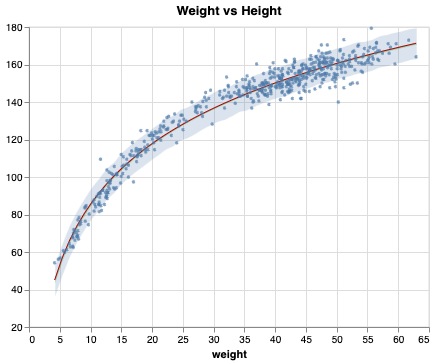

In [41]:
compatibility_band = (
    alt.Chart(df)
    .encode(alt.X("weight"))
    .mark_area(opacity=0.3, color="#00AA00")
    .encode(alt.Y("mu_high", axis=alt.Axis(title=None)), alt.Y2("mu_low"))
)

prediction_band = (
    alt.Chart(df)
    .encode(alt.X("weight"))
    .mark_area(opacity=0.2)
    .encode(alt.Y("h_high"), alt.Y2("h_low"))
)

map_line = (
    alt.Chart(df)
    .mark_line(color="#AA0000", strokeWidth=1)
    .encode(x="weight", y="h_map")
)

# alt.layer(compatibility_band, prediction_band, data_chart)
compatibility_band + prediction_band + map_line + data_chart

## 4H4

Plot the prior predictive distribution for the polynomial regression model in the chapter. You can modify the code that plots the linear regression prior predictive distribution. Can you modify the prior distributions of α, β1, and β2 so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to keep the curves consistent with what you know about height and weight, before seeing these exact data.

In [42]:
# take full Howell dataset
height = howell1["height"]
weight = howell1["weight"]

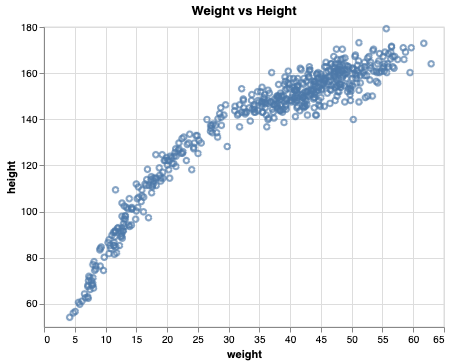

In [43]:
df = pd.DataFrame({"height": height, "weight": weight})

data_chart = (
    alt.Chart(df, title="Weight vs Height")
    .mark_point()
    .encode(
        alt.X("weight", scale=alt.Scale(zero=False)),
        alt.Y("height", scale=alt.Scale(zero=False)),
    )
)
data_chart

In [44]:
# normalize variables
height_mean = height.mean()
height_std = height.std()

weight_mean = weight.mean()
weight_std = weight.std()

height_normed = (height - height_mean) / height_std
weight_normed = (weight - weight_mean) / weight_std

In [45]:
height_normed = height_normed.to_numpy()
weight_normed = weight_normed.to_numpy()

In [46]:
code = """
data {
  int<lower=0> n;
  vector[n] weight;
  vector[n] height;
}
parameters {
  real alpha;
  real<lower=0> beta1;
  real beta2;
  real sigma;
}
model {
  // despite the requirements, we cheat and fit priors by hand
  alpha ~ normal(100, 40);
  beta1 ~ lognormal(1, 0.1);
  beta2 ~ normal(-1, 1);
  sigma ~ normal(25, 15);
  
  vector[n] mu = alpha + beta1 * weight + beta2 * weight^2;
  height ~ normal(mu, sigma);
}
"""

# set empty data, to sample from priors
data = {"n": 0, "weight": [], "height": []}

In [47]:
%%capture
# capture output because stan is too spammy when building model
prior = stan.build(code, data=data, random_seed=42)

In [48]:
%%capture
prior_fit = prior.sample(num_chains=4, num_samples=1000)

In [49]:
prior_fit_df = prior_fit.to_frame()
prior_fit_df[["alpha", "beta1", "beta2", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,4000.0,100.937788,39.976647,-61.200519,73.738916,101.856727,127.782160,237.736736
beta1,4000.0,2.726052,0.263771,1.875661,2.539155,2.708712,2.900455,3.650315
beta2,4000.0,-1.000534,0.972702,-4.593909,-1.660419,-1.011668,-0.346895,2.310330
sigma,4000.0,26.679011,13.459997,0.020062,16.568349,25.987634,35.432429,85.248234


In [50]:
weight_grid = np.linspace(weight.min(), weight.max())

lines = []

prior_pred_df = pd.DataFrame({"weight": [], "height": []})

for i in range(20):
    a = prior_fit_df["alpha"][i]
    b1 = prior_fit_df["beta1"][i]
    b2 = prior_fit_df["beta2"][i]
    s = prior_fit_df["sigma"][i]

    w = (weight_grid - weight_mean) / weight_std

    mu = a + b1 * w + b2 * w * w

    prior_pred = np.random.normal(mu, s)

    prior_pred_df = pd.concat(
        [prior_pred_df, pd.DataFrame({"weight": weight_grid, "height": prior_pred})]
    )

    df = pd.DataFrame({"weight": weight_grid, "height": mu})

    line_chart = (
        alt.Chart(df)
        .mark_line(color="#00AA00", strokeWidth=0.5, opacity=0.5)
        .encode(
            x="weight",
            y="height",
        )
    )

    lines.append(line_chart)

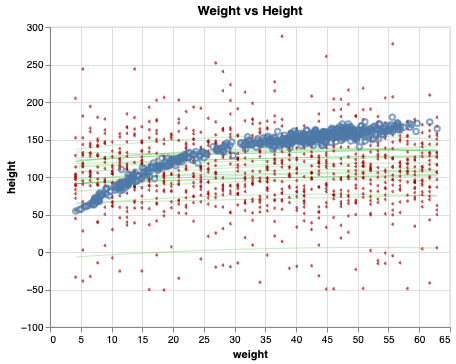

In [51]:
prior_pred_chart = (
    alt.Chart(prior_pred_df)
    .mark_point(color="#AA0000", size=1)
    .encode(
        alt.X("weight"),
        alt.Y("height"),
    )
)

reduce(lambda a, b: a + b, lines) + prior_pred_chart + data_chart